In [91]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [135]:
import time
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from enum import Enum, IntEnum

import numpy as np
import pandas as pd
from torch import nn
from torchsummary import summary
import torch
print (f'torch.__version__: {torch.__version__}')
import cv2 as cv
from torchvision import transforms
import pickle

import enums
import viz
import configuration
import customdataset
import transformers
import models
import feature_helpers
from utilmethods import create_output_folders, check_torch_mps_device, make_torch_deterministic

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, validation_curve
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from scipy.stats import loguniform

from tqdm.notebook import tqdm

# check_torch_mps_device()
# device = 'cpu'
# device = 'mps'

config = configuration.Configuration()
face_config = configuration.FaceConfig(config)
pose_config = configuration.PoseConfig(config)
feature_extractor = feature_helpers.FeatureExtractor(config, face_config, pose_config, tqdm)

LABELS_TO_INCLUDE = config.class_dict.keys()
# LABELS_TO_INCLUDE=[0,1,2,9]

IMAGE_TYPES = [enums.ImageTypes.ORIGINAL, enums.ImageTypes.POSE_ANNOTATED, enums.ImageTypes.FACE]
FEATURES = [enums.FeatureType.CNN, enums.FeatureType.KEYPOINTS]

torch.__version__: 1.13.0


In [3]:
%%time
# Load the data
data = feature_extractor.load_data(image_types=IMAGE_TYPES, 
                                   labels=LABELS_TO_INCLUDE, 
                                   shuffle=True, 
                                   sample_type=enums.SampleType.TRAIN_VALIDATION,
                                   count_per_label=540,
                                   include_feature_vectors=False)
y = data[enums.DataColumn.LABEL.value]
train_idx, val_idx = train_test_split(np.arange(len(y)), test_size=0.2, random_state=config.SEED)

# Load CNN and Keypoints features
all_features = feature_extractor.load_feature_vectors(config.FEATURE_VECTORS_FOLDER, 
                                                      data[enums.DataColumn.FILENAME.value], 
                                                      data[enums.DataColumn.LABEL.value],
                                                      features=set(FEATURES))
[cnn_features, keypoints_features, _, _] = all_features


Loading 5400 samples:   0%|          | 0/5400 [00:00<?, ?samples/s]

Loading feature vectors:   0%|          | 0/5400 [00:00<?, ?images/s]

CPU times: user 32min 3s, sys: 2min 27s, total: 34min 31s
Wall time: 6min 14s


In [15]:
# Summarize data and features loaded.
print(f'Loaded {data.shape[0]} samples with {data.columns} columns.')
print(f'cnn_features:{cnn_features.shape}, cnn_features.min:{np.min(cnn_features)}, cnn_features.max:{np.max(cnn_features)}')
print(f'keypoints_features:{keypoints_features.shape}, keypoints_features.min:{np.min(keypoints_features)}, keypoints_features.max:{np.max(keypoints_features)}')
print(f'Training dataset size: {len(train_idx)}; Validation dataset size: {len(val_idx)}')
print()

Loaded 5400 samples with Index(['filename', 'label', 'original', 'pose_annotated', 'face'], dtype='object') columns.
cnn_features:(5400, 2048), cnn_features.min:0.0, cnn_features.max:1.607669472694397
keypoints_features:(5400, 26), keypoints_features.min:-0.5003660321235657, keypoints_features.max:0.9989637667923688
Training dataset size: 4320; Validation dataset size: 1080



## Principal Components

In [5]:
# Helpers for vizualizing
def plot_PCA(X_list, names, n_components, max_components, out_file='pca.jpg', ):
    pca_list, xpca_list = feature_extractor.get_PCA(X_list, n_components=n_components)
    plt.figure(figsize=(15,5))
    colors = ['b-', 'g-', 'r-', 'k-', 'y-']
    plot_labels = [f'{name} features' for name in names]
    for i in range(len(X_list)):
        plt.plot(np.cumsum(pca_list[i].explained_variance_ratio_), colors[i], label=plot_labels[i])
    # plt.xticks(np.arange(max_components)+1)
    plt.yticks(np.linspace(0, 1, 8))
    plt.grid(visible=True)
    plt.xlabel('Number of components')
    plt.ylabel('Explained Variances')
    plt.legend()
    plt.title('Explaining Power Of Principal Components')
    plt.tight_layout(pad=0.1, h_pad=None, w_pad=None, rect=None)
    plt.savefig(f'{config.OUTPUT_FOLDER}/report_plots/{out_file}', dpi=300)
    plt.show()

def plot_classes(X, y, ax, title, included_labels):
    colormap = plt.cm.gist_rainbow # hsv tab20 #nipy_spectral #, Set1,Paired
    colorst = [colormap(i) for i in np.linspace(0, 1.0, len(np.unique(y)))]
    markers = ['o', 'v', 's', 'p', 'x', '>', '*', '<', 'P', '^']
    for k, label in enumerate(included_labels):
        marker = markers[k % len(markers)]
        if X.shape[1] == 2:
            ax.scatter(X[y==label, 0], X[y==label, 1], facecolors=colorst[k], marker=marker, label=config.class_dict[label])
        else:
            ax.scatter(X[y==label, 0], X[y==label, 1], X[y==label, 2], facecolors=colorst[k], marker=marker, label=config.class_dict[label])
    ax.set_title(title)
    
def plot_components(features_list, X_pcas, X_tsnes, names, included_labels=LABELS_TO_INCLUDE, out_file='clustering.jpg'):
    # project the features into 2 dimensions
    fig, ax = plt.subplots(nrows=len(features_list), ncols=2, figsize=(10,5))
    if len(features_list) == 1:
        ax = [ax]

    # y is the class labels
    for i in range(len(features_list)):
        plot_classes(X_pcas[i], y, ax[i][0], title=f'{names[i]} PCA', included_labels=LABELS_TO_INCLUDE)
        plot_classes(X_tsnes[i], y, ax[i][1], title=f'{names[i]} tSNE', included_labels=LABELS_TO_INCLUDE)
    
    handles, plot_labels = ax[0][0].get_legend_handles_labels()
    fig.legend(handles, plot_labels, loc='upper center')
    plt.tight_layout(pad=0.1, h_pad=None, w_pad=12, rect=None)
    plt.savefig(f'{config.OUTPUT_FOLDER}/report_plots/{out_file}', dpi=300)
    plt.show()

Doing PCA([200, 26]):   0%|          | 0/2 [00:00<?, ?images/s]

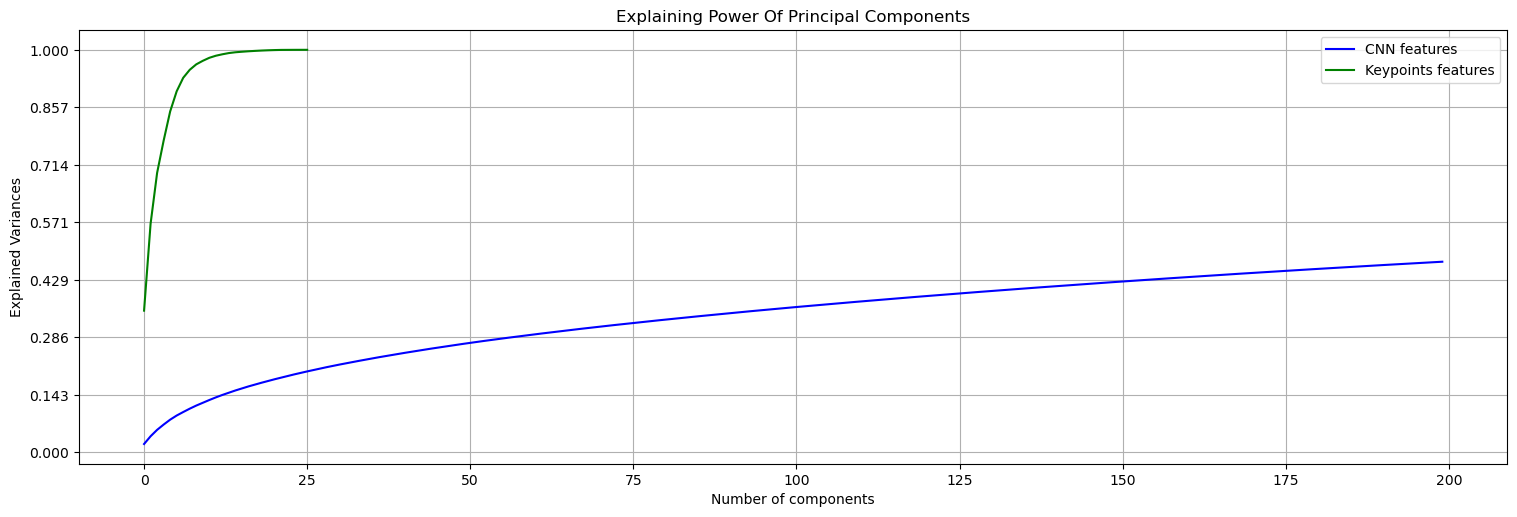

CPU times: user 3.73 s, sys: 169 ms, total: 3.9 s
Wall time: 1.05 s


In [6]:
%%time
plot_PCA([cnn_features, keypoints_features], ['CNN', 'Keypoints'], n_components=[200, 26], max_components=200, out_file=f'pca.jpg')

Doing PCA([2, 2]):   0%|          | 0/2 [00:00<?, ?images/s]

Doing tSNE(2):   0%|          | 0/2 [00:00<?, ?images/s]

/Users/rasentha/opt/anaconda3/envs/amd-gpu2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/Users/rasentha/opt/anaconda3/envs/amd-gpu2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


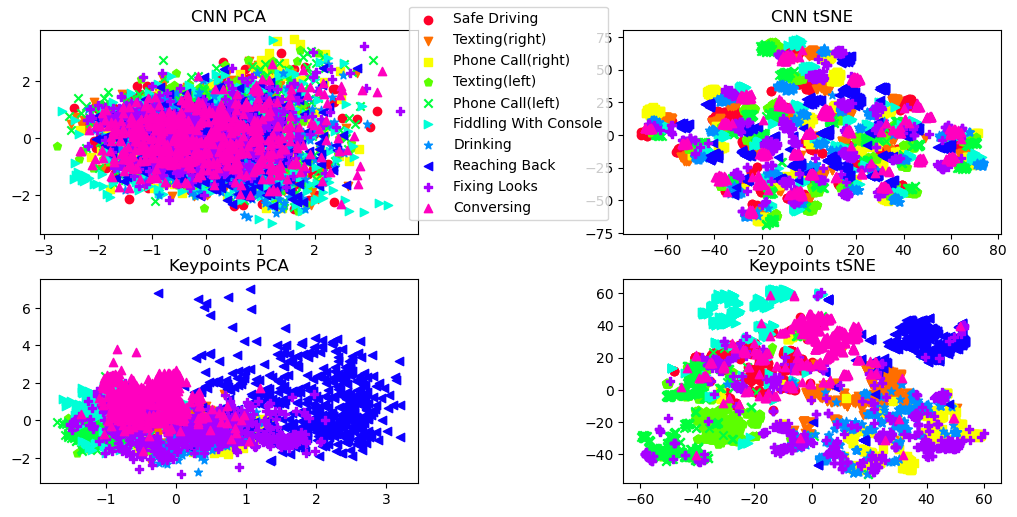

CPU times: user 2min 48s, sys: 3.67 s, total: 2min 52s
Wall time: 31 s


In [9]:
%%time
def visualize_components():
    features_list = [cnn_features, keypoints_features]
    n_components = [2, 2]
    names = ['CNN', 'Keypoints']
    pcas = feature_extractor.get_PCA(features_list, n_components)[-1]
    tsnes = feature_extractor.get_tsne(features_list, n_components=2)
    plot_components(features_list, pcas, tsnes, names, included_labels=LABELS_TO_INCLUDE)
visualize_components()

## KNN Classification

In [38]:
print(y[train_idx].shape)
print(y[train_idx][4016:4016])

(4320,)
Series([], Name: label, dtype: int64)


/var/folders/s4/p0y554f56hd_d9fk8y79dy3c0000gs/T/ipykernel_13026/238404006.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  print(y[train_idx][4016:4016])


In [75]:
%%time
def calc_accuracy(pca, y_train, idx, model_name):
    knn = KNeighborsClassifier(n_neighbors = 3)
    knn.fit(pca, y_train)
    filename = f'{config.SAVED_MODELS_FOLDER}/knn_{model_name}.pkl'
    with open(filename, 'wb') as file:
        pickle.dump(knn, file)
    
    accuracy = 0
    
    for i in idx:
        label = knn.predict([pca[i,:]])
        if label[0] == y_train[i]:
            accuracy +=1
    return accuracy

def accuracies(n_samples):
    y_train = y[train_idx].tolist()
    idx = list(np.random.choice(np.arange(len(y_train)), n_samples, replace=False))

    # Get the principal components
    [X_keypoints_pca] = feature_extractor.get_PCA([keypoints_features], n_components=[14])[-1]
    X_keypoints_pca = X_keypoints_pca[train_idx]

    [X_keypoints_tsne] = feature_extractor.get_tsne([keypoints_features], n_components=2)
    X_keypoints_tsne = X_keypoints_tsne[train_idx]

    print(f'Accuracies from {n_samples} training samples:')
    print('Keypoints PCA Accuracy: ', calc_accuracy(X_keypoints_pca, y_train, idx, 'keypoints_pca')/n_samples)
    print('Keypoints tSNE Accuracy: ', calc_accuracy(X_keypoints_tsne, y_train, idx, 'keypoints_tsne')/n_samples)

accuracies(1000)

Doing PCA([14]):   0%|          | 0/1 [00:00<?, ?images/s]

Doing tSNE(2):   0%|          | 0/1 [00:00<?, ?images/s]

/Users/rasentha/opt/anaconda3/envs/amd-gpu2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


Accuracies from 1000 training samples:
Keypoints PCA Accuracy:  0.956
Keypoints tSNE Accuracy:  0.943


## Logistic Regression

### Create Model

In [104]:
def train_classifier(in_feat, in_y, in_train_idx, val_idx):
    # get the train and validation split
    X_train = in_feat[in_train_idx, :].copy()
    y_train = in_y[in_train_idx].copy()
    X_val = in_feat[val_idx, :].copy()
    y_val = in_y[val_idx].copy()

    # scaling
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)

    # classifier with cross validation
    
    # 1e-5, 1e-4, 1e-3, ..., 1, 10, 100,
    param_grid = {"C": loguniform(1e-3, 1e5)}
    # clf = RandomizedSearchCV(LogisticRegression(solver='liblinear', random_state=config.SEED), param_grid, n_iter=100)
    clf = RandomizedSearchCV(LogisticRegression(penalty='l1', max_iter=5000, solver='saga', random_state=config.SEED), param_grid, n_iter=10)
    clf = clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)

    return metrics.accuracy_score(y_val, y_pred)

def plot_accuracy_graph(keypoints_acc, n_components, out_file='keypoints_logit_accuracy.jpg'):
    # plot the accuracy graph
    plt.figure(figsize=(15,5))
    # plt.plot(np.array(pixel_acc)*100, 'b-', label='pixel features')
    # plt.plot(np.array(pose_acc)*100, 'g-', label='pose features')
    # plt.plot(np.array(CNN_acc)*100, 'k-', label='CNN features')

    plt.plot(np.array(keypoints_acc)*100, 'b-', label='keypoints features')

    xtick_labels = [f'{i+1}' for i in n_components] + ['All']
    plt.xticks(np.arange(len(n_components) + 1), labels=xtick_labels)
    plt.yticks(np.linspace(0, 100, 11))
    plt.grid(b=True)
    plt.xlabel('Number of components')
    plt.ylabel('Accuracy')
    # plt.ylim([0, 100])
    plt.legend()
    plt.savefig(f'{config.OUTPUT_FOLDER}/report_plots/{out_file}', dpi=300)
    plt.show()
    
def train_and_check(features, n_components, name, y, train_idx, val_idx):
    pbar = tqdm(desc=name, total=len(n_components) + 1, position=0, leave=True)
    acc = []
    for n in n_components:
        pbar.set_description(f'{name}: Computing PCA({n})')
        _, X = feature_extractor.get_PCA([features], n_components=[n+1])
        acc.append(train_classifier(X[0], y, train_idx, val_idx))
        pbar.update(1)
    pbar.set_description(f'{name}: Training classifier')
    acc.append(train_classifier(features, y, train_idx, val_idx))
    pbar.update(1)
    pbar.close()
    plot_accuracy_graph(acc, n_components)
    return acc

Keypoints Feature Accuracy


Keypoints:   0%|          | 0/7 [00:00<?, ?it/s]

Doing PCA([2]):   0%|          | 0/1 [00:00<?, ?images/s]

Doing PCA([6]):   0%|          | 0/1 [00:00<?, ?images/s]

Doing PCA([11]):   0%|          | 0/1 [00:00<?, ?images/s]

Doing PCA([16]):   0%|          | 0/1 [00:00<?, ?images/s]

Doing PCA([21]):   0%|          | 0/1 [00:00<?, ?images/s]

Doing PCA([24]):   0%|          | 0/1 [00:00<?, ?images/s]

/var/folders/s4/p0y554f56hd_d9fk8y79dy3c0000gs/T/ipykernel_13026/2443562878.py:36: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True)


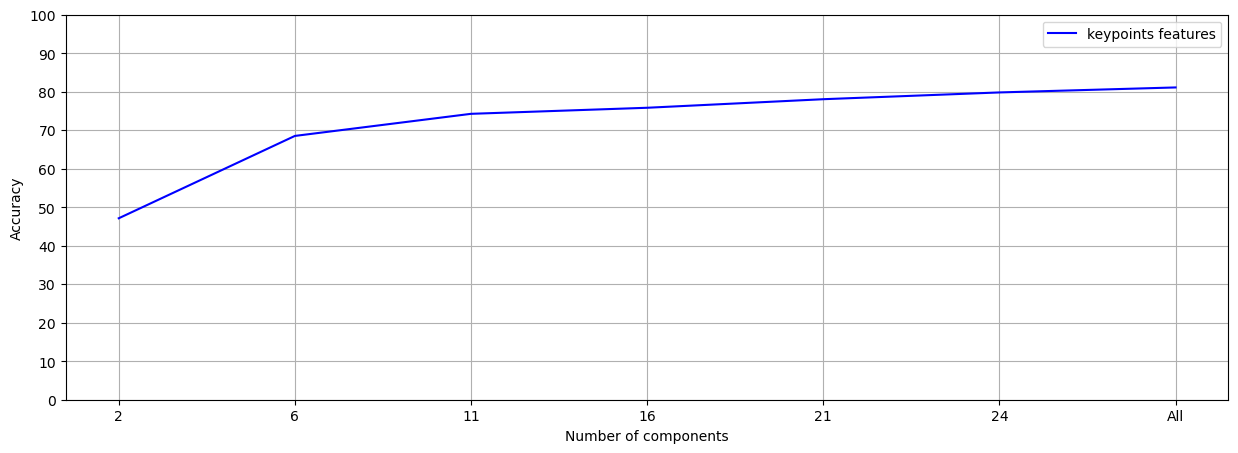

CPU times: user 25min 38s, sys: 9.17 s, total: 25min 47s
Wall time: 22min 15s


[0.47129629629629627,
 0.6851851851851852,
 0.7425925925925926,
 0.7583333333333333,
 0.7805555555555556,
 0.7981481481481482,
 0.8111111111111111]

In [105]:
%%time

print('Keypoints Feature Accuracy')
train_and_check(keypoints_features, [1, 5, 10, 15, 20, 23], 'Keypoints', y, train_idx, val_idx)


In [131]:
def logit_classifier(features, y, train_idx, val_idx, grid_params, feature_name, 
                     model_name, max_iter=5000, penalty='l1', solver='saga', scoring='neg_log_loss'):
    # get the train and validation split
    X_train = features[train_idx, :].copy()
    y_train = y[train_idx].copy()
    X_val = features[val_idx, :].copy()
    y_val = y[val_idx].copy()

    # scaling
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)

    # Save scaler for future use.
    pickle.dump(scaler, open(f'{config.SAVED_MODELS_FOLDER}/scaler_{model_name}_{feature_name}.pkl','wb'))

    # classifier with cross validation
    # clf = RandomizedSearchCV(LogisticRegression(solver='liblinear', random_state=config.SEED), param_grid, n_iter=100)
    clf = RandomizedSearchCV(LogisticRegression(penalty=penalty, solver=solver, random_state=config.SEED, max_iter=max_iter),
                       grid_params, return_train_score=True, scoring=scoring)
    # clf = RandomizedSearchCV(LogisticRegression(penalty='elasticnet', solver='saga', random_state=config.SEED, max_iter=max_iter),
    #                    grid_params, return_train_score=True, scoring='neg_log_loss')
    clf = clf.fit(X_train, y_train)
    pickle.dump(clf, open(f'{config.SAVED_MODELS_FOLDER}/model_{model_name}_{feature_name}.pkl', 'wb'))
    
    y_pred = clf.predict(X_val)
    return clf, metrics.accuracy_score(y_val, y_pred)

def create_lr_keypoints_pca_model():
    # Parameter space for random search hyper parameter tuning.
    # grid_params = {
    #     'C': loguniform(1e-3, 1e5),
    #     'l1_ratio': [.3, .4, .5, 0.55, 0.6, 0.65, .7, .8, .9, 1.0],}

    # grid_params = {
    #     'C': loguniform(50, 1e2),
    #     'l1_ratio': loguniform(0.3, 0.9)}

    # Parameter space for random search hyper parameter tuning.
    n_components = 16
    grid_params = {
        'C': loguniform(1e-2, 1e3)}

    # Random search of hyper parameters
    # logit_clf, accuracy = logit_classifier(keypoints_features, y, train_idx, val_idx, grid_params=grid_params)
    [keypoints_pca],[X_keypoints_pca] = feature_extractor.get_PCA([keypoints_features], n_components=[n_components])
    print(len(X_keypoints_pca))
    
    #save the PCA
    keypoints_pca
    pickle.dump(keypoints_pca, open(f'{config.SAVED_MODELS_FOLDER}/model_pca_{n_components}_keypoints_pca.pkl', 'wb'))
    logit_pca_clf, logit_pca_accuracy = logit_classifier(X_keypoints_pca, y, train_idx, val_idx, grid_params, 'keypoints_pca', 'logistic')
    
def create_lr_keypoints_model():
    # Parameter space for random search hyper parameter tuning.
    # grid_params = {
    #     'C': loguniform(1e-3, 1e5),
    #     'l1_ratio': [.3, .4, .5, 0.55, 0.6, 0.65, .7, .8, .9, 1.0],}

    # grid_params = {
    #     'C': loguniform(50, 1e2),
    #     'l1_ratio': loguniform(0.3, 0.9)}

    # Parameter space for random search hyper parameter tuning.
    grid_params = {
        'C': loguniform(1e-2, 1e3)}

    # Random search of hyper parameters
    # logit_clf, accuracy = logit_classifier(keypoints_features, y, train_idx, val_idx, grid_params=grid_params)    
    logit_pca_clf, logit_pca_accuracy = logit_classifier(keypoints_features, y, train_idx, val_idx, grid_params, 'keypoints', 'logistic')


In [132]:
%%time

create_lr_keypoints_pca_model()
# create_lr_keypoints_model()

Doing PCA([16]):   0%|          | 0/1 [00:00<?, ?images/s]

5400
CPU times: user 2min 29s, sys: 1.1 s, total: 2min 30s
Wall time: 1min 42s


### Test Against Validation Dataset

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.78      0.78       121
           1       0.88      0.93      0.90       113
           2       0.76      0.68      0.71       120
           3       0.71      0.72      0.71        97
           4       0.66      0.67      0.67       106
           5       0.90      0.86      0.88       104
           6       0.61      0.65      0.63       101
           7       0.96      0.92      0.94       110
           8       0.54      0.56      0.55       101
           9       0.78      0.79      0.79       107

    accuracy                           0.76      1080
   macro avg       0.76      0.76      0.76      1080
weighted avg       0.76      0.76      0.76      1080

Accuracy: 0.7583333333333333


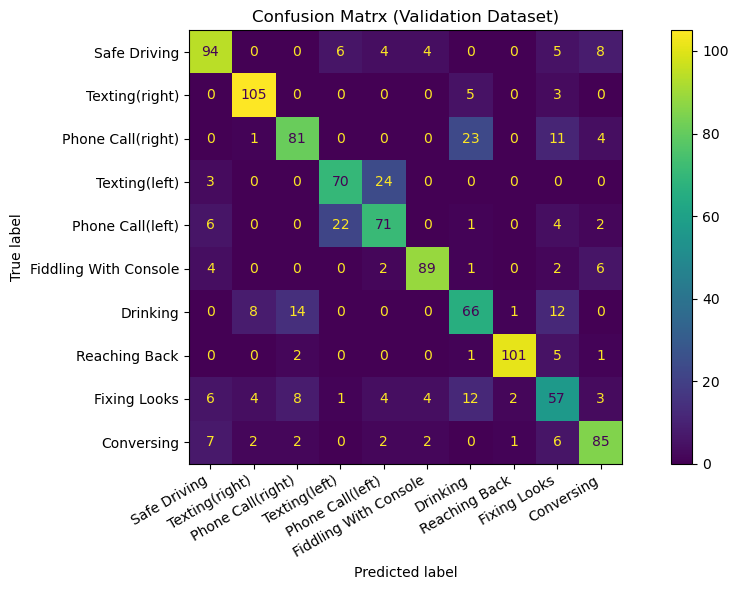

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.84      0.83       121
           1       0.84      0.94      0.89       113
           2       0.79      0.79      0.79       120
           3       0.84      0.84      0.84        97
           4       0.80      0.77      0.78       106
           5       0.91      0.88      0.89       104
           6       0.66      0.68      0.67       101
           7       1.00      0.92      0.96       110
           8       0.61      0.58      0.60       101
           9       0.81      0.81      0.81       107

    accuracy                           0.81      1080
   macro avg       0.81      0.81      0.81      1080
weighted avg       0.81      0.81      0.81      1080

Accuracy: 0.8083333333333333


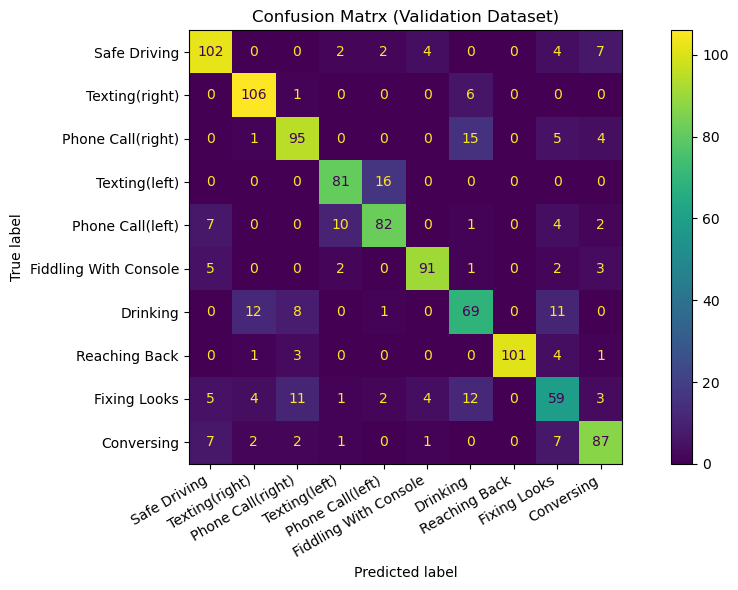

In [143]:
def load_saved_model(model_filename):
    filename = f'{config.SAVED_MODELS_FOLDER}/{model_filename}'
    with open(filename, 'rb') as file:
        return pickle.load(file)

def check_against_ds(X, y, model_name, feature_name, dataset_name, model_filename, scaler_file_name):
    out_file = f'confusion_matrix_{model_name}_{feature_name}_{dataset_name}.jpg'

    with open(model_filename, 'rb') as modelfile, open(scaler_file_name, 'rb') as scalerfile:
        model = pickle.load(modelfile)
        scaler = pickle.load(scalerfile)
        X_val = scaler.transform(X)
        y_pred = model.predict(X_val)
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.set_title(f'Confusion Matrx ({dataset_name} Dataset)')
        disp_labels = [config.class_dict[key] for key in sorted(config.class_dict.keys())]
        cm = metrics.confusion_matrix(y, y_pred, labels=model.classes_)
        
        result1 = metrics.classification_report(y, y_pred)
        print('Classification Report:',)
        print (result1)
        result2 = metrics.accuracy_score(y, y_pred)
        print('Accuracy:',result2)
        
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=disp_labels)
        disp.plot(xticks_rotation='30', ax=ax)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')        
        plt.subplots_adjust(bottom=0.3)
        plt.savefig(f'{config.OUTPUT_FOLDER}/report_plots/{out_file}', dpi=300)
        plt.tight_layout()        
        plt.show()

    # Visualize images that the model got very wrong.
    
def test_pca_lr_validation_ds():
    X_val = keypoints_features[val_idx, :].copy()
    y_val = y[val_idx].copy()
    # Load the pca model and transform X
    with open(f'{config.SAVED_MODELS_FOLDER}/model_pca_16_keypoints_pca.pkl', 'rb') as pca_modelfile:
        pca_model =  pickle.load(pca_modelfile)
        X_val = pca_model.transform(X_val)
        
        check_against_ds(X_val, y_val, dataset_name='Validation', 
                         model_name='logistic', feature_name='keypoints_pca',
                         model_filename = f'{config.SAVED_MODELS_FOLDER}/model_logistic_keypoints_pca.pkl',
                         scaler_file_name = f'{config.SAVED_MODELS_FOLDER}/scaler_logistic_keypoints_pca.pkl')

test_pca_lr_validation_ds()
check_against_ds(keypoints_features[val_idx, :].copy(), 
                y[val_idx].copy(), dataset_name='Validation', 
                model_name='logistic', feature_name='keypoints',
                model_filename = f'{config.SAVED_MODELS_FOLDER}/model_logistic_keypoints.pkl',
                scaler_file_name = f'{config.SAVED_MODELS_FOLDER}/scaler_logistic_keypoints.pkl')

### Test Against Holdout Dataset

Loading 600 samples:   0%|          | 0/600 [00:00<?, ?samples/s]

Loading feature vectors:   0%|          | 0/600 [00:00<?, ?images/s]

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.82      0.80        60
           1       0.85      0.92      0.88        60
           2       0.76      0.85      0.80        60
           3       0.82      0.85      0.84        60
           4       0.84      0.78      0.81        60
           5       0.91      0.88      0.90        60
           6       0.78      0.75      0.76        60
           7       0.95      0.97      0.96        60
           8       0.67      0.57      0.61        60
           9       0.87      0.87      0.87        60

    accuracy                           0.82       600
   macro avg       0.82      0.82      0.82       600
weighted avg       0.82      0.82      0.82       600

Accuracy: 0.825


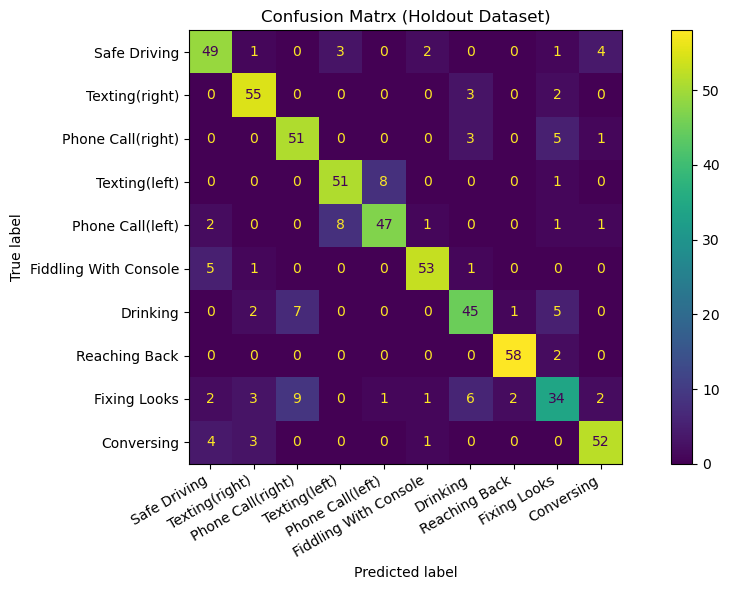

In [145]:
def test_models_against_holdout():
    hold_data = feature_extractor.load_data(image_types=IMAGE_TYPES,
                                       labels=LABELS_TO_INCLUDE,
                                       shuffle=True, 
                                       sample_type=enums.SampleType.TEST,
                                       include_feature_vectors=False)
    y_holdout = hold_data[enums.DataColumn.LABEL.value]

    # Load CNN and Keypoints features
    all_features = feature_extractor.load_feature_vectors(config.FEATURE_VECTORS_FOLDER, 
                                                          hold_data[enums.DataColumn.FILENAME.value], 
                                                          hold_data[enums.DataColumn.LABEL.value],
                                                          features=set(FEATURES))
    [holdout_cnn_features, holdout_keypoints_features, _, _] = all_features
    
    check_against_ds(holdout_keypoints_features, 
                y_holdout, dataset_name='Holdout',
                model_name='logistic', feature_name='keypoints',
                model_filename = f'{config.SAVED_MODELS_FOLDER}/model_logistic_keypoints.pkl',
                scaler_file_name = f'{config.SAVED_MODELS_FOLDER}/scaler_logistic_keypoints.pkl')

test_models_against_holdout()    